In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

In [6]:
data = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv')
data.columns = [x.strip() for x in data.columns.tolist()]
X = data.drop(columns = ['url', 'shares', 'timedelta'])
y = data['shares']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)
# Total variables I dropped
total_dropped = 0

In [24]:
# Using Linear Regression as a base model to judge error 
base_model = LinearRegression().fit(X_train, y_train)
pred = base_model.predict(X_test)
print("Base model MAE: {}".format(mean_absolute_error(y_test, pred)))
base_model_mae = 2947.18999587914

Base model MAE: 2947.1899958791887


<AxesSubplot: xlabel='y_test', ylabel='predictions'>

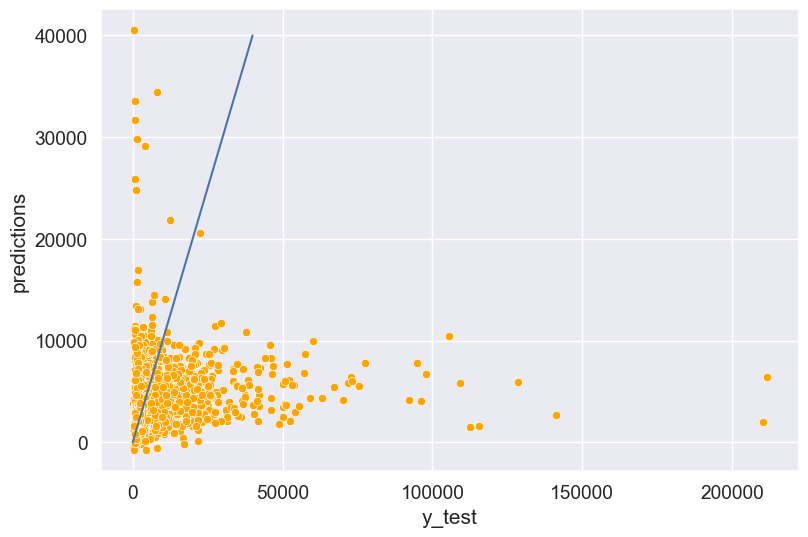

In [10]:
#Plotting residuals vs fitted values
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = y_test, y=pred,color = 'orange')
plt.xlabel('y_test')
plt.ylabel('predictions')
sns.lineplot(x = [0, 40000], y = [0, 40000])

# Data Visualization to see if any predictors or the response is skewed

[Text(0.5, 0, 'Shares'), Text(0.5, 1.0, '"shares" Distribution (raw)')]

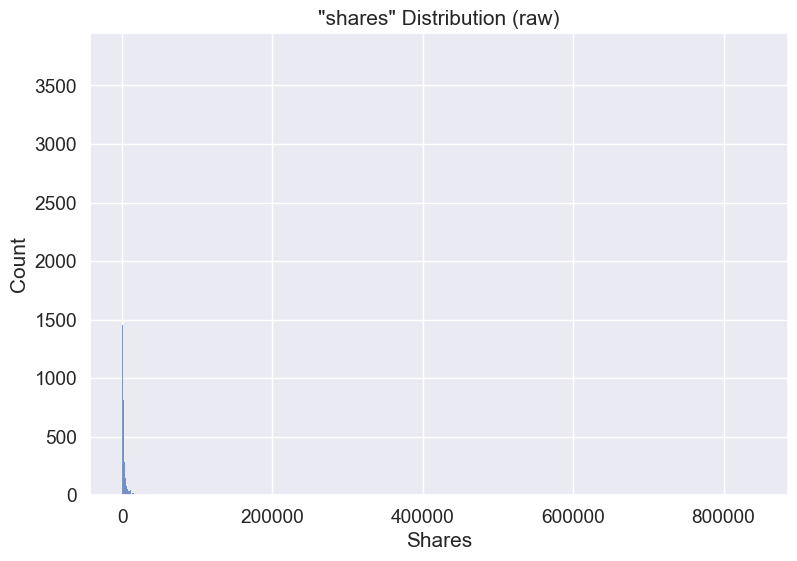

In [14]:
# As you can see the response variable is extremely skewed and has some extreme outliers in its data points.
# Therefore using a log transformation on the predictor is likely to be very helpful
fig, ax = plt.subplots()
sns.histplot(data.shares)
ax.set(xlabel = 'Shares', title = '"shares" Distribution (raw)')

(0.0, 25000.0)

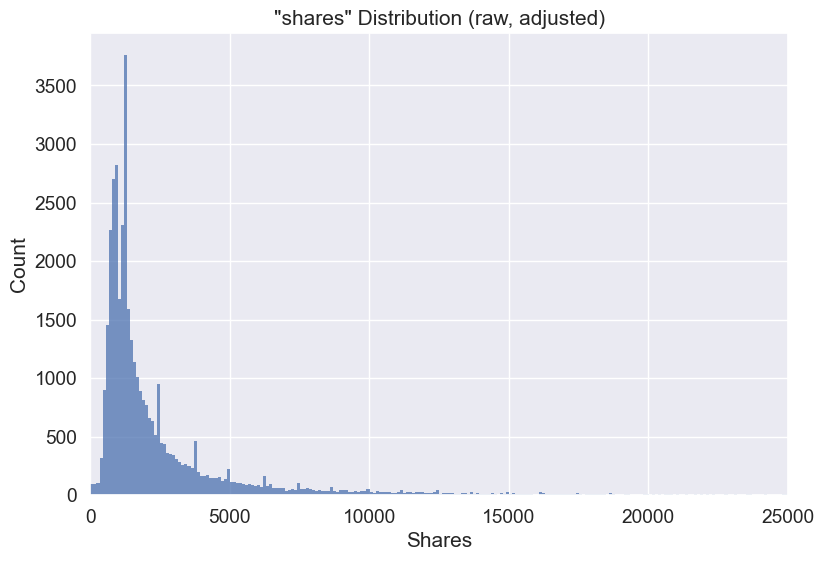

In [20]:
# As you can see the response variable is extremely skewed and has some extreme outliers in its data points.
# Therefore using a log transformation on the predictor is likely to be very helpful
fig, ax = plt.subplots()
sns.histplot(data.shares)
ax.set(xlabel = 'Shares', title = '"shares" Distribution (raw, adjusted)')
ax.set_xlim([0, 25000])

In [18]:
print('"shares" mean = {}'.format(data.shares.mean()))
print('"shares" standard deviation = {}'.format(data.shares.std()))

"shares" mean = 3395.3801836343455
"shares" standard deviation = 11626.950748651712


In [21]:
print('logged "shares" mean = {}'.format(np.log(data.shares).mean()))
print('logged "shares" standard deviation = {}'.format(np.log(data.shares).std()))

logged "shares" mean = 7.4748549241986275
logged "shares" standard deviation = 0.9304860893713806


[Text(0.5, 0, 'np.log(shares)'),
 Text(0.5, 1.0, 'Logged "shares" Distribution')]

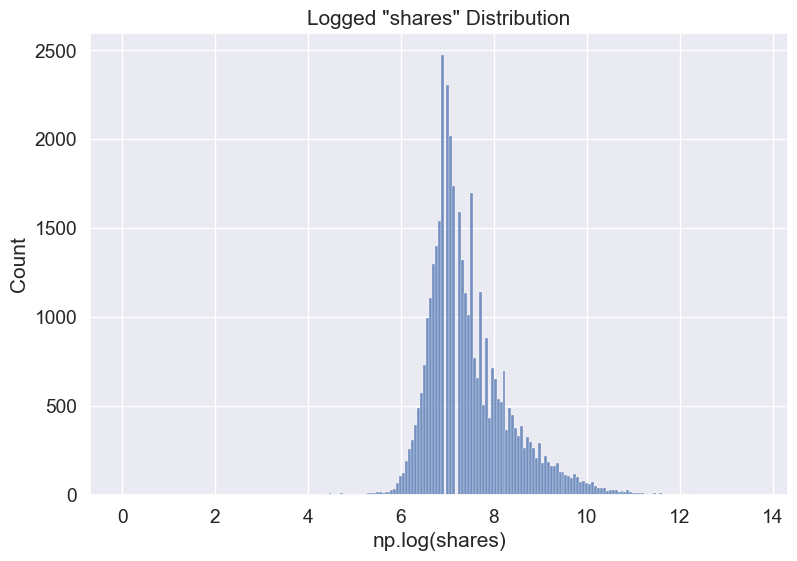

In [16]:
# Scaling with a log transformation looks extremely helpful, and thus looks like something we must do in all our models
# to assist with model prediction
fig, ax = plt.subplots()
sns.histplot(np.log(data.shares))
ax.set(xlabel = 'np.log(shares)', title = 'Logged "shares" Distribution')
# None of the data points are incorrect because they were directly taken from the source and were hard data

In [10]:
# Testing fit after adjusting for outliers in data
base_model = LinearRegression().fit(X_train, np.log(y_train))
pred = base_model.predict(X_test)
print('diff between base_model and transformed response model is {}', base_model_mae - mean_absolute_error(y_test, np.exp(pred)))
# Accuracy gets better for MAE with scaling, so will do from now on
mean_absolute_error(y_test, np.exp(pred))

diff between base_model and transformed response model is {} 600.5581969469704


2346.6317989321697

In [11]:
# Using Linear Regression as a base model to judge error 
base_model = LinearRegression().fit(X_train, np.log(y_train))
pred = base_model.predict(X_test)
print(mean_absolute_error(y_test, np.exp(pred)))
base_model_mae = 2346.6317989298423

2346.6317989321697


In [12]:
# Percent of data.shares that is considered outliers
third = data.shares.quantile(0.75)
first = data.shares.quantile(0.25)
IQR = third - first
num = data.shares.apply(lambda x: True if (x < first - 2*IQR) else True if (x > third + 2*IQR) else False).sum()
num
print(round(num / data.shares.count() * 100, 2))

# Going to investigate which predictors have more than 5% of their data points being outliers
def find_outliers(series):
    third = series.quantile(0.75)
    first = series.quantile(0.25)
    IQR = third - first
    if (series.apply(lambda x: True if (x < first - 2*IQR) else True if (x > third + 2*IQR) else False).sum()) > 1982:
        return True
    else:
        return False
        
data.drop(columns = 'url').loc[:,data.drop(columns = 'url').apply(lambda x: find_outliers(x), axis = 0)].columns

9.31


Index(['n_non_stop_words', 'num_imgs', 'num_videos',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_min_max',
       'kw_max_max', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'title_sentiment_polarity', 'shares'],
      dtype='object')

In [13]:
# Many of the above data values are just largely all 0's and 1's for data points, or just have a few extremely huge outliers,
# and as such there would be no use in scaling them

In [14]:
# Dropping any variables with zero variance
dropped1 = X_train.var(numeric_only = True)[X_train.var(numeric_only = True) == 0].index.tolist()
# There are none with zero variance
len(dropped1)

0

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
# Will remove variables with the highest values of VIF
to_drop = ['weekday_is_monday', 'weekday_is_saturday', 'LDA_00', 'n_unique_tokens', 'n_non_stop_words', 'self_reference_avg_sharess',
          'rate_positive_words']
# The variables right now result in the lowest rmse we can get, all other variable removals increase the rmse
X = add_constant(X_train.drop(columns = to_drop))
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)   

total_dropped += len(to_drop)
# Total variables dropped due to multicollinearity is 9
base_model = LinearRegression().fit(X_train.drop(columns = to_drop), y_train)
pred = base_model.predict(X_test.drop(columns = to_drop))
print('base mae = {}'.format(base_model_mae))
print('new_model mae = {}'.format(mean_absolute_error(y_test, pred)))
print('diff mae = {}'.format(mean_absolute_error(y_test, pred) - base_model_mae))

base mae = 2346.6317989298423
new_model mae = 2944.2887556406804
diff mae = 597.6569567108381


In [16]:
# Since better difference, remove the predictors entirely
X_train.drop(columns = to_drop, inplace = True)
X_test.drop(columns = to_drop, inplace = True)
all_dropped_predictors = []
for x in to_drop:
    all_dropped_predictors.append(x)

In [22]:
data.shape

(39644, 61)

In [17]:
# Now for the key part, removing variables with high level of correlation with one another
# Using coarse grid for correlation to reject between variables
correlation_range = [(x / 10) for x in range(0, 11, 1)]
maes = pd.DataFrame()

iteration = 0
for correlation in correlation_range:
    actual_columns_drop = []
    columns_to_drop = []
    X_train_copy = X_train.copy()
    while (True):
        try:
            # Systematically remove variables one by one from dataset copy based on correlation, 
            # and break when no more variables to remove
            correlations = X_train_copy.corr(numeric_only = True)
            first_column = correlations.iloc[0].name
            index = correlations[first_column].apply(lambda x: 
                                                     False if x == 1 else True if (np.abs(x) > correlation) else False)
            to_drop = correlations[first_column].loc[index].index.tolist()
            columns_to_drop.append(to_drop)
            X_train_copy = X_train_copy.drop(columns = to_drop).drop(columns = first_column)
        except:
            break
            
    # Make column list of lists of columns into one list of columns
    for columns in columns_to_drop:
        for column in columns:
            actual_columns_drop.append(column)
            
    # Create new model based off of new columns to drop, and then add the mae to mae
    model = LinearRegression().fit(X_train.drop(columns = actual_columns_drop), np.log(y_train))
    pred = model.predict(X_test.drop(columns = actual_columns_drop))
    model_mae = mean_absolute_error(y_test, np.exp(pred))
    
    maes.loc[iteration, 'MAE'] = model_mae
    maes.loc[iteration, 'correlation'] = correlation
    maes.loc[iteration, 'diff_MAE'] = model_mae - base_model_mae
    maes.loc[iteration, 'model'] = model
    maes.loc[iteration, 'total_dropped'] = len(actual_columns_drop)
    iteration += 1

In [18]:
# based off of the MAES I'm seeing in the dataframe below, we can see that the RMSE generally doesn't rise all that much
# As the correlation decreases. The differences in the MAE show, however, that the correlation we should investigate is somewhere
# within the range of 0.3 - 1.0
rmses

,MAE,correlation,diff_MAE,model,total_dropped
0,2376.217700,0.0,29.585901,LinearRegression(),50.0
1,2366.838762,0.1,20.206963,LinearRegression(),40.0
2,2359.546681,0.2,12.914882,LinearRegression(),34.0
3,2330.523312,0.3,-16.108486,LinearRegression(),24.0
4,2324.640043,0.4,-21.991756,LinearRegression(),21.0
5,2328.696946,0.5,-17.934853,LinearRegression(),15.0
6,2318.411931,0.6,-28.219868,LinearRegression(),10.0
7,2318.400205,0.7,-28.231594,LinearRegression(),10.0
8,2317.661764,0.8,-28.970035,LinearRegression(),4.0
9,2366.003096,0.9,19.371297,LinearRegression(),1.0


In [19]:
# Fine correlation search
# Now for the key part, removing variables with high level of correlation with one another
# Using coarse grid for correlation to reject between variables
correlation_range = [(x / 100) for x in range(30, 90, 5)]
rmses = pd.DataFrame()

iteration = 0
for correlation in correlation_range:
    actual_columns_drop = []
    columns_to_drop = []
    X_train_copy = X_train.copy()
    while (True):
        try:
            # Systematically remove variables one by one from dataset copy based on correlation, and break when no more variables to remove
            correlations = X_train_copy.corr(numeric_only = True)
            first_column = correlations.iloc[0].name
            index = correlations[first_column].apply(lambda x: False if x == 1 else True if (np.abs(x) > correlation) else False)
            to_drop = correlations[first_column].loc[index].index.tolist()
            columns_to_drop.append(to_drop)
            X_train_copy = X_train_copy.drop(columns = to_drop).drop(columns = first_column)
        except:
            break
            
    # Make column list of lists of columns into one list of columns
    for columns in columns_to_drop:
        for column in columns:
            actual_columns_drop.append(column)
            
    # Create new model based off of new columns to drop, and then add the rmse to rmses
    model = LinearRegression().fit(X_train.drop(columns = actual_columns_drop), np.log(y_train))
    pred = model.predict(X_test.drop(columns = actual_columns_drop))
    model_rmse = mean_absolute_error(y_test, np.exp(pred))
    
    rmses.loc[iteration, 'MAE'] = model_rmse
    rmses.loc[iteration, 'correlation'] = correlation
    rmses.loc[iteration, 'diff_MAE'] = model_rmse - base_model_mae
    rmses.loc[iteration, 'model'] = model
    rmses.loc[iteration, 'total_dropped'] = len(actual_columns_drop)
    iteration += 1

In [20]:
# When looking at the difference in MAE, we can see that the correlation to aim for when removing predictors is either
# 0.5 - 0.58 or 0.84-1.0. However, given that the difference in MAE spikes and then falls back down again once we reach 15 
# total dropped suggests that there is a variable that is a significant detriment to our model quality that is removed when we 
# go to a correlation of 0.5. Given that the "spike" in MAE is not that much, if that variable does not end up being that
# significant in reducing MAE as we thought, it still wouldn't significantly impact out model.
rmses

# Therefore we will do one more final fine search in the correlation from 0.4 - 0.6 to find the best correlation to choose

,MAE,correlation,diff_MAE,model,total_dropped
0,2330.523312,0.30,-16.108486,LinearRegression(),24.0
1,2329.399771,0.35,-17.232028,LinearRegression(),22.0
2,2324.640043,0.40,-21.991756,LinearRegression(),21.0
3,2321.507984,0.45,-25.123815,LinearRegression(),20.0
4,2328.696946,0.50,-17.934853,LinearRegression(),15.0
5,2328.333511,0.55,-18.298288,LinearRegression(),14.0
6,2318.411931,0.60,-28.219868,LinearRegression(),10.0
7,2318.400205,0.65,-28.231594,LinearRegression(),10.0
8,2318.400205,0.70,-28.231594,LinearRegression(),10.0
9,2317.604593,0.75,-29.027206,LinearRegression(),6.0


In [21]:
# Fine correlation search
# Now for the key part, removing variables with high level of correlation with one another
# Using coarse grid for correlation to reject between variables
correlation_range = [(x / 100) for x in range(60, 83, 1)]
rmses = pd.DataFrame()

new_columns = []
iteration = 0
for correlation in correlation_range:
    actual_columns_drop = []
    columns_to_drop = []
    X_train_copy = X_train.copy()
    while (True):
        try:
            # Systematically remove variables one by one from dataset copy based on correlation, and break when no more variables to remove
            correlations = X_train_copy.corr(numeric_only = True)
            first_column = correlations.iloc[0].name
            index = correlations[first_column].apply(lambda x: False if x == 1 else True if (np.abs(x) > correlation) else False)
            to_drop = correlations[first_column].loc[index].index.tolist()
            columns_to_drop.append(to_drop)
            X_train_copy = X_train_copy.drop(columns = to_drop).drop(columns = first_column)
        except:
            break
            
    # Make column list of lists of columns into one list of columns
    for columns in columns_to_drop:
        for column in columns:
            actual_columns_drop.append(column)
            
    # Create new model based off of new columns to drop, and then add the rmse to rmses
    model = LinearRegression().fit(X_train.drop(columns = actual_columns_drop), np.log(y_train))
    pred = model.predict(X_test.drop(columns = actual_columns_drop))
    model_rmse = mean_absolute_error(y_test, np.exp(pred))
    
    rmses.loc[iteration, 'MAE'] = model_rmse
    rmses.loc[iteration, 'correlation'] = correlation
    rmses.loc[iteration, 'diff_MAE'] = model_rmse - base_model_mae
    rmses.loc[iteration, 'model'] = model
    rmses.loc[iteration, 'total_dropped'] = len(actual_columns_drop)
    new_columns.append(actual_columns_drop)
    iteration += 1

In [22]:
# We can find that the best correlation to choose to remove variables is 0.72, 0.73, or 0.74
rmses

,MAE,correlation,diff_MAE,model,total_dropped
0,2318.411931,0.60,-28.219868,LinearRegression(),10.0
1,2318.411931,0.61,-28.219868,LinearRegression(),10.0
2,2318.411931,0.62,-28.219868,LinearRegression(),10.0
3,2318.400205,0.63,-28.231594,LinearRegression(),10.0
4,2318.400205,0.64,-28.231594,LinearRegression(),10.0
5,2318.400205,0.65,-28.231594,LinearRegression(),10.0
6,2318.400205,0.66,-28.231594,LinearRegression(),10.0
7,2318.400205,0.67,-28.231594,LinearRegression(),10.0
8,2318.400205,0.68,-28.231594,LinearRegression(),10.0
9,2318.400205,0.69,-28.231594,LinearRegression(),10.0


In [23]:
# Final dataset is this one
X_train.drop(columns = new_columns[13], inplace = True)
X_test.drop(columns = new_columns[13], inplace = True)

In [29]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def create_autoencoder(input_dim, encoding_dim):
    """
    Creates a simple autoencoder.
    
    Parameters:
    input_dim (int): The number of input features.
    encoding_dim (int): The number of neurons in the encoding layer.
    
    Returns:
    autoencoder (keras.models.Model): The autoencoder model.
    """
    # Input layer
    input_layer = Input(shape=(input_dim,))
    
    # Encoding layer
    encoding_layer = Dense(encoding_dim, activation='relu')(input_layer)
    
    # Decoding layer
    decoding_layer = Dense(input_dim, activation='sigmoid')(encoding_layer)
    
    # Autoencoder
    autoencoder = Model(input_layer, decoding_layer)
    
    return autoencoder

In [38]:
x = X.copy()
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Split the data into train, validation, and test sets
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=42)

# Define the size of the compressed representation
encoding_dim = 16 
# Define the input layer
input_data = tf.keras.layers.Input(shape=(x.shape[1],))

# Define the encoding layer
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_data)

# Define the decoding layer
decoded = tf.keras.layers.Dense(x.shape[1], activation='sigmoid')(encoded)

# Define the autoencoder model
autoencoder = tf.keras.Model(input_data, decoded)

# Define the encoder model
encoder = tf.keras.Model(input_data, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_val, x_val))

# Use the encoder to transform the input data
x_train_encoded = encoder.predict(x_train)
x_val_encoded = encoder.predict(x_val)
x_test_encoded = encoder.predict(x_test)

# Now you can use `x_train_encoded`, `x_val_encoded`, and `x_test_encoded` for your machine learning model

Epoch 1/50
100/100 [==============================] - 1s 6ms/step - loss: 12160336896.0000 - val_loss: 12102700032.0000
Epoch 2/50
100/100 [==============================] - 1s 5ms/step - loss: 12160335872.0000 - val_loss: 12102700032.0000
Epoch 3/50
100/100 [==============================] - 1s 5ms/step - loss: 12160336896.0000 - val_loss: 12102700032.0000
Epoch 4/50
100/100 [==============================] - 0s 5ms/step - loss: 12160334848.0000 - val_loss: 12102700032.0000
Epoch 5/50
100/100 [==============================] - 0s 5ms/step - loss: 12160335872.0000 - val_loss: 12102700032.0000
Epoch 6/50
100/100 [==============================] - 0s 5ms/step - loss: 12160335872.0000 - val_loss: 12102700032.0000
Epoch 7/50
100/100 [==============================] - 0s 5ms/step - loss: 12160336896.0000 - val_loss: 12102700032.0000
Epoch 8/50
100/100 [==============================] - 0s 5ms/step - loss: 12160334848.0000 - val_loss: 12102700032.0000
Epoch 9/50
100/100 [====================

In [37]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define a list of encoding dimensions to try
encoding_dims = [16, 32, 64, 128]

# Initialize a variable to keep track of the best encoding dimension and the best loss
best_encoding_dim = None
best_loss = float('inf')

# For each encoding dimension...
for encoding_dim in encoding_dims:
    # Define the input layer
    input_data = tf.keras.layers.Input(shape=(x.shape[1],))

    # Define the encoding layer
    encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_data)

    # Define the decoding layer
    decoded = tf.keras.layers.Dense(x.shape[1], activation='sigmoid')(encoded)

    # Define the autoencoder model
    autoencoder = tf.keras.Model(input_data, decoded)

    # Compile the autoencoder
    autoencoder.compile(optimizer='adam', loss='mse')

    # Train the autoencoder
    autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_val, x_val), verbose=0)

    # Calculate the validation loss
    val_loss = autoencoder.evaluate(x_val, x_val, verbose=0)

    # If this loss is the best we've seen, update the best loss and the best encoding dimension
    if val_loss < best_loss:
        best_loss = val_loss
        best_encoding_dim = encoding_dim

print(f'Best encoding dimension: {best_encoding_dim}, Best validation loss: {best_loss}')



Best encoding dimension: 16, Best validation loss: 12102692864.0


In [44]:
x_train = x_train_encoded.copy()
x_test = x_test_encoded.copy()

n_samples = x_train.shape[0]
n_features = x_train.shape[1]

param_grid = {'n_estimators': [100, 200, 300, 400],
              'max_features': [10, 40, 70],
              'max_depth': [20, 35, 50],
              'bootstrap': [True, False],
              'oob_score': [True, False]}

cv = KFold(n_splits=5, shuffle=True, random_state=45)
rf_grid = GridSearchCV(RandomForestRegressor(random_state=45, n_jobs=-1),
                       param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1, scoring='neg_mean_absolute_error')
rf_grid.fit(x_train, y_train)

best_params = rf_grid.best_params_
best_score = -rf_grid.best_score_

print(f"Best parameters: {best_params}")
print(f"Best negative mean absolute error: {best_score}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jackokeefe/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator

Best parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 10, 'n_estimators': 400, 'oob_score': True}
Best negative mean absolute error: 3413.6523139718934
